In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import fastai
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error
import pickle as pkl
from tqdm import tqdm
from math import sqrt

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
oex_tickers = ["AAPL", "ABBV", "ABT", "ACN","ADBE","AIG", "ALL", "AMGN", "AMT", "AMZN", "AXP", "BA", "BAC","BIIB","BK","BKNG","BLK","BMY","C","CAT","CHTR","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX","DD","DHR","DIS","DUK","EMR","EXC","F","FB","FDX","GD","GE","GILD","GM","GOOG","GOOGL","GS","HD","HON","IBM","INTC","JNJ","JPM","KHC","KMI","KO","LLY","LMT","LOW","MA","MCD","MDLZ","MDT","MET","MMM","MO","MRK","MS","MSFT","NEE","NFLX","NKE","NVDA","ORCL","OXY","PEP","PFE","PG","PM","PYPL","QCOM","RTX","SBUX","SLB","SO","SPG","T","TGT","TMO","UNH","UNP","UPS","USB","V","VZ","WBA","WFC","WMT","XOM"]

In [4]:
training_data = pd.read_pickle("data_dump/training_oex_5y_data.pkl")
training_data = training_data.drop(["OW", "BRK.B", "XN"])

FileNotFoundError: [Errno 2] No such file or directory: 'data_dump/training_oex_5y_data.pkl'

# For 6 Feb

Add ARIMA, Theta models, AR1, AR2, VAR(?)

Have one ensemble of that, have one ensemble of previous ML algorithms, have one ensemble of all of them. 

Then track performance of each

In [5]:
from utils.general import training_data_for_t
from sklearn.linear_model import SGDRegressor
import time
from core import Position, PositionType
from utils.general import change_above_threshold

def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades(predictions, ground_truth, thresholds=None, slowed=False, verbose=False, print_result = False):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        if next_prediction > 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif next_prediction < 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None
        
            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time

ModuleNotFoundError: No module named 'utils'

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


def fit_base_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
#     blender.fit(meta_X, y_val)
    return meta_X

def predict_base_ensemble(models, X_val):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return meta_X

def fit_meta_ensemble(meta_X, y_val, meta_model):
    meta_model.fit(meta_X, y_val)
    return meta_model

def fit_full_ensemble(models, X_train, X_val, y_train, y_val, meta_model):
    meta = fit_base_ensemble(models, X_train, X_val, y_train, y_val)
    return fit_meta_ensemble(meta, y_val, meta_model)


def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_test)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

In [9]:
from methods.svm import SVM
from preparers import ticker_default
from core.functions import forecast
from core.simulation import simulate_trades_continuous
from utils.viz import plot_time_series, plot_balance, plot_balance_vs_price
from utils.general import differentiate, inv_differentiate

ModuleNotFoundError: No module named 'methods'

# ARIMA

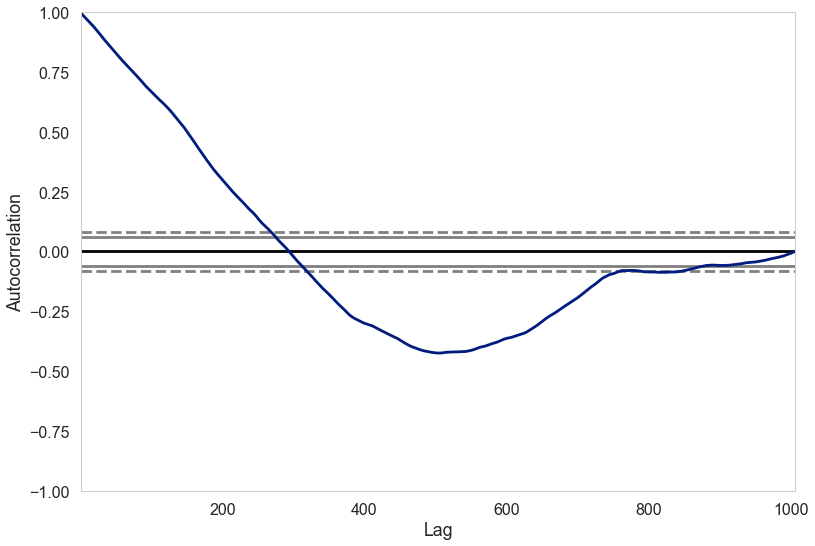

In [50]:
from pandas.plotting import autocorrelation_plot

#Check autocorrelation plot to determine best lag time for ARIMA

autocorr_data = training_data.loc["NVDA"].dropna().reset_index(drop=True)
autocorrelation_plot(autocorr_data)


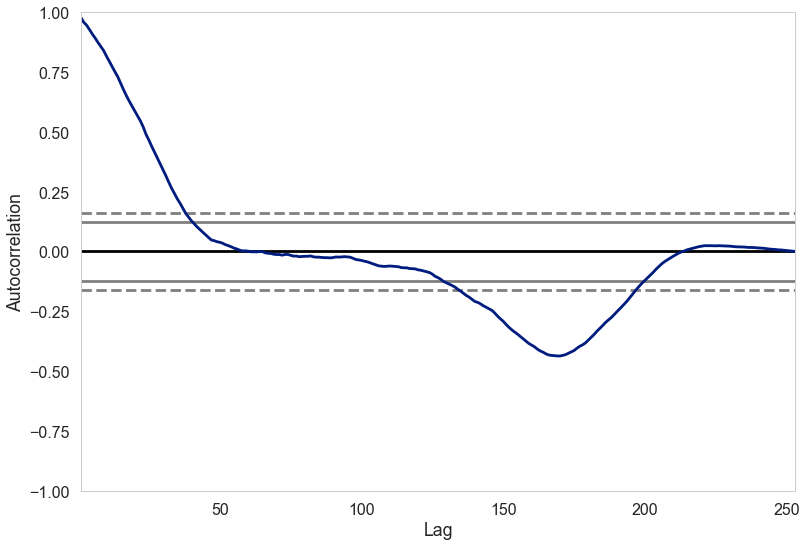

In [52]:
from pandas.plotting import autocorrelation_plot

#Check autocorrelation plot to determine best lag time for ARIMA

autocorr_data_short = training_data.loc["XOM"].dropna().reset_index(drop=True)[253:506]
autocorrelation_plot(autocorr_data_short)

In [10]:
from statsmodels.tsa.arima.model import ARIMA
# def find_optimal_arima_lag
model = ARIMA(autocorr_data, order=(30,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

NameError: name 'autocorr_data' is not defined

In [11]:
from statsmodels.tsa.arima.model import ARIMA
# def find_optimal_arima_lag
model = ARIMA(autocorr_data[:start_t], order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

NameError: name 'autocorr_data' is not defined

Above cell shows that residuals don't change much even if lag is 5 or 30 for NVDA due to high autocorrelation below 40-50 lag as shown in above plot

In [12]:
import time
from core import Position, PositionType
from utils.general import change_above_threshold

"""
Liquidates a given Position and returns the new balance
"""


def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
        print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
        print(log) if verbose else None

    return updated_balance


"""
Simulation in format of:
    - If open position -> close by selling or buying back
    - Decide on next position
    - Repeat

Decisions to buy / sell happen continuously each day
"""


def simulate_trades_continuous(predictions, ground_truth, thresholds=0, slowed=False, verbose=False):
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0

    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None

        if curr_price < next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif curr_price > next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log)

    return balance_over_time

ModuleNotFoundError: No module named 'core'




  0%|          | 0/880 [00:00<?, ?it/s]

Predicting ARIMA with no thresholding





  0%|          | 1/880 [00:00<03:07,  4.70it/s]


  0%|          | 2/880 [00:00<03:28,  4.22it/s]


  0%|          | 3/880 [00:00<03:44,  3.90it/s]


  0%|          | 4/880 [00:01<04:44,  3.08it/s]


  1%|          | 5/880 [00:01<04:20,  3.36it/s]


  1%|          | 6/880 [00:01<04:17,  3.40it/s]


  1%|          | 7/880 [00:02<04:08,  3.51it/s]


  1%|          | 8/880 [00:02<03:44,  3.88it/s]


  1%|          | 9/880 [00:02<03:44,  3.89it/s]


  1%|          | 10/880 [00:02<03:31,  4.12it/s]


  1%|▏         | 11/880 [00:02<03:31,  4.12it/s]


  1%|▏         | 12/880 [00:03<03:25,  4.22it/s]


  1%|▏         | 13/880 [00:03<03:20,  4.32it/s]


  2%|▏         | 14/880 [00:03<03:16,  4.41it/s]


  2%|▏         | 15/880 [00:03<03:09,  4.56it/s]


  2%|▏         | 16/880 [00:04<03:10,  4.53it/s]


  2%|▏         | 17/880 [00:04<03:09,  4.55it/s]


  2%|▏         | 18/880 [00:04<03:07,  4.61it/s]


  2%|▏         | 19/880 [00:04<03:08,  4.57it/s]


  2%|▏         | 20/880 [00:04<03:16,

 30%|███       | 266/880 [00:47<01:33,  6.53it/s]


 30%|███       | 267/880 [00:48<01:30,  6.76it/s]


 30%|███       | 268/880 [00:48<01:29,  6.81it/s]


 31%|███       | 269/880 [00:48<01:30,  6.72it/s]


 31%|███       | 270/880 [00:48<01:27,  6.93it/s]


 31%|███       | 271/880 [00:48<01:32,  6.57it/s]


 31%|███       | 272/880 [00:48<01:31,  6.64it/s]


 31%|███       | 273/880 [00:48<01:33,  6.48it/s]


 31%|███       | 274/880 [00:49<01:34,  6.39it/s]


 31%|███▏      | 275/880 [00:49<01:33,  6.50it/s]


 31%|███▏      | 276/880 [00:49<01:32,  6.53it/s]


 31%|███▏      | 277/880 [00:49<01:32,  6.51it/s]


 32%|███▏      | 278/880 [00:49<01:34,  6.37it/s]


 32%|███▏      | 279/880 [00:49<01:34,  6.37it/s]


 32%|███▏      | 280/880 [00:50<01:34,  6.34it/s]


 32%|███▏      | 281/880 [00:50<01:32,  6.47it/s]


 32%|███▏      | 282/880 [00:50<01:36,  6.19it/s]


 32%|███▏      | 283/880 [00:50<01:36,  6.19it/s]


 32%|███▏      | 284/880 [00:50<01:36,  6.20it/s]


 32%|███▏   

 61%|██████    | 534/880 [01:34<01:11,  4.86it/s]


 61%|██████    | 535/880 [01:34<01:09,  4.99it/s]


 61%|██████    | 536/880 [01:34<01:15,  4.56it/s]


 61%|██████    | 537/880 [01:35<01:20,  4.28it/s]


 61%|██████    | 538/880 [01:35<01:17,  4.42it/s]


 61%|██████▏   | 539/880 [01:35<01:20,  4.25it/s]


 61%|██████▏   | 540/880 [01:35<01:19,  4.29it/s]


 61%|██████▏   | 541/880 [01:36<01:27,  3.89it/s]


 62%|██████▏   | 542/880 [01:36<01:22,  4.09it/s]


 62%|██████▏   | 543/880 [01:36<01:14,  4.53it/s]


 62%|██████▏   | 544/880 [01:36<01:11,  4.70it/s]


 62%|██████▏   | 545/880 [01:36<01:15,  4.43it/s]


 62%|██████▏   | 546/880 [01:37<01:08,  4.87it/s]


 62%|██████▏   | 547/880 [01:37<01:09,  4.80it/s]


 62%|██████▏   | 548/880 [01:37<01:12,  4.57it/s]


 62%|██████▏   | 549/880 [01:37<01:14,  4.47it/s]


 62%|██████▎   | 550/880 [01:37<01:10,  4.70it/s]


 63%|██████▎   | 551/880 [01:38<01:06,  4.98it/s]


 63%|██████▎   | 552/880 [01:38<01:09,  4.73it/s]


 63%|██████▎

 91%|█████████ | 802/880 [02:27<00:14,  5.24it/s]


 91%|█████████▏| 803/880 [02:27<00:15,  4.94it/s]


 91%|█████████▏| 804/880 [02:28<00:15,  5.03it/s]


 91%|█████████▏| 805/880 [02:28<00:15,  4.98it/s]


 92%|█████████▏| 806/880 [02:28<00:14,  5.26it/s]


 92%|█████████▏| 807/880 [02:28<00:13,  5.53it/s]


 92%|█████████▏| 808/880 [02:28<00:12,  5.73it/s]


 92%|█████████▏| 809/880 [02:28<00:11,  5.93it/s]


 92%|█████████▏| 810/880 [02:29<00:11,  6.19it/s]


 92%|█████████▏| 811/880 [02:29<00:11,  6.25it/s]


 92%|█████████▏| 812/880 [02:29<00:10,  6.30it/s]


 92%|█████████▏| 813/880 [02:29<00:10,  6.26it/s]


 92%|█████████▎| 814/880 [02:29<00:10,  6.13it/s]


 93%|█████████▎| 815/880 [02:29<00:10,  6.33it/s]


 93%|█████████▎| 816/880 [02:29<00:09,  6.45it/s]


 93%|█████████▎| 817/880 [02:30<00:09,  6.72it/s]


 93%|█████████▎| 818/880 [02:30<00:09,  6.82it/s]


 93%|█████████▎| 819/880 [02:30<00:08,  6.91it/s]


 93%|█████████▎| 820/880 [02:30<00:08,  7.13it/s]


 93%|███████

RMSE of forecasting:  4.9937932693310945
Simulation done. Executed 879 trades, Final Balance: 11.219833374023438


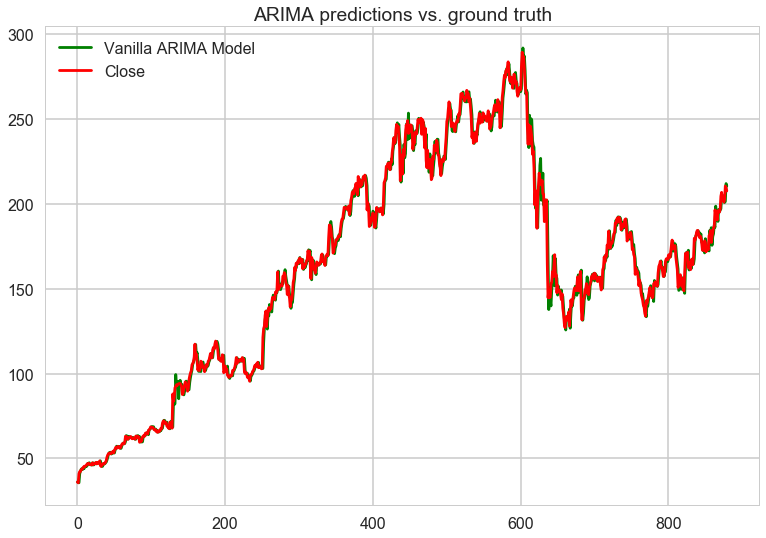

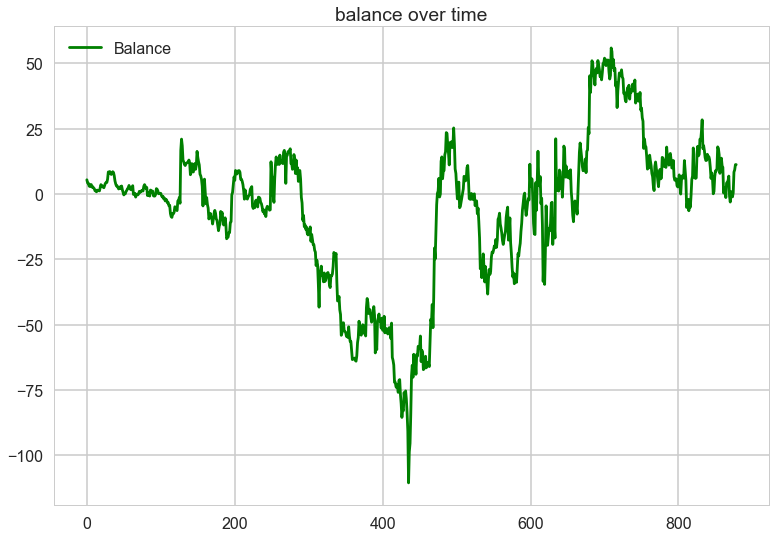

In [54]:
first_df = training_data.loc["NVDA"].dropna()

data = first_df.reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df.to_numpy(), int(num_days_year/2)

predictions = list()
thresholds = []
training_X = data[:start_t].reset_index(drop=True)

test_X = data[start_t:].reset_index(drop=True)

print("Predicting ARIMA with no thresholding")
for t_i in tqdm(range(len(data) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    model = ARIMA(data[t_i:current_t], order = (10,1,0))
    fitted_model = model.fit()
    prediction = fitted_model.forecast().reset_index(drop=True)
    predictions.append(prediction[0])

print("RMSE of forecasting: ", sqrt(mean_squared_error(test_X, predictions)))
balances_arima = simulate_trades_continuous(predictions, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions, ts_label_1='Vanilla ARIMA Model', ts_2=first_df[start_t:], ts_label_2='Close', title='ARIMA predictions vs. ground truth')
plot_balance(data=balances_arima)


Stationarity test for prices
ADF Statistic: -1.377354
p-value: 0.593084
Stationarity test for returns (1st order differentiation)
ADF Statistic: -12.066043
p-value: 0.000000


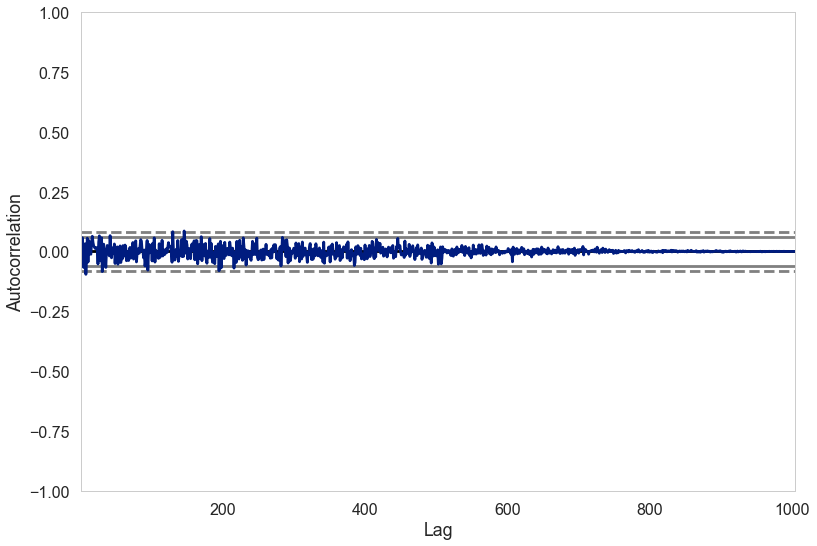

In [38]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)
from statsmodels.tsa.stattools import adfuller
from numpy import log
print("Stationarity test for prices")
result_original = adfuller(first_df.reset_index(drop=True))
print('ADF Statistic: %f' % result_original[0])
print('p-value: %f' % result_original[1])
print("Stationarity test for returns (1st order differentiation)")
result_differentiated = adfuller(y_features)
print('ADF Statistic: %f' % result_differentiated[0])
print('p-value: %f' % result_differentiated[1])


autocorrelation_plot(y_features)

In [42]:
from utils.general import training_data_for_t
from sklearn.linear_model import SGDRegressor
import time
from core import Position, PositionType
from utils.general import change_above_threshold

def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades_returns(predictions, ground_truth, thresholds=None, slowed=False, verbose=False, print_result = False):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        if next_prediction > 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif next_prediction < 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None
        
            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time



  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 2/878 [00:00<00:53, 16.31it/s]

Predicting with no thresholding




  0%|          | 4/878 [00:00<00:53, 16.33it/s]

  1%|          | 6/878 [00:00<00:51, 16.84it/s]

  1%|          | 8/878 [00:00<00:49, 17.56it/s]

  1%|▏         | 11/878 [00:00<00:47, 18.27it/s]

  1%|▏         | 13/878 [00:00<00:48, 17.80it/s]

  2%|▏         | 15/878 [00:00<00:52, 16.36it/s]

  2%|▏         | 17/878 [00:00<00:52, 16.36it/s]

  2%|▏         | 19/878 [00:01<00:50, 17.08it/s]

  2%|▏         | 21/878 [00:01<00:49, 17.23it/s]

  3%|▎         | 23/878 [00:01<00:49, 17.13it/s]

  3%|▎         | 25/878 [00:01<00:49, 17.09it/s]

  3%|▎         | 27/878 [00:01<00:49, 17.04it/s]

  3%|▎         | 29/878 [00:01<00:51, 16.56it/s]

  4%|▎         | 31/878 [00:01<00:52, 16.24it/s]

  4%|▍         | 33/878 [00:02<00:59, 14.27it/s]

  4%|▍         | 35/878 [00:02<01:03, 13.33it/s]

  4%|▍         | 37/878 [00:02<01:04, 13.05it/s]

  4%|▍         | 39/878 [00:02<01:04, 13.07it/s]

  5%|▍         | 41/878 [00:02<01:01, 13.66it/s]

  5%|▍         | 43/878 [00:02<00:56, 14.75it/s]

 

 50%|████▉     | 438/878 [00:40<01:01,  7.20it/s]

 50%|█████     | 440/878 [00:40<00:55,  7.93it/s]

 50%|█████     | 441/878 [00:40<01:00,  7.22it/s]

 50%|█████     | 442/878 [00:40<00:58,  7.39it/s]

 51%|█████     | 444/878 [00:40<00:53,  8.10it/s]

 51%|█████     | 446/878 [00:41<00:49,  8.71it/s]

 51%|█████     | 448/878 [00:41<00:47,  9.05it/s]

 51%|█████     | 449/878 [00:41<00:46,  9.29it/s]

 51%|█████▏    | 450/878 [00:41<00:46,  9.23it/s]

 51%|█████▏    | 451/878 [00:41<00:46,  9.18it/s]

 52%|█████▏    | 453/878 [00:41<00:44,  9.52it/s]

 52%|█████▏    | 455/878 [00:41<00:43,  9.78it/s]

 52%|█████▏    | 456/878 [00:42<00:42,  9.82it/s]

 52%|█████▏    | 458/878 [00:42<00:42,  9.98it/s]

 52%|█████▏    | 460/878 [00:42<00:41, 10.09it/s]

 53%|█████▎    | 462/878 [00:42<00:41, 10.10it/s]

 53%|█████▎    | 464/878 [00:42<00:44,  9.35it/s]

 53%|█████▎    | 465/878 [00:43<00:44,  9.25it/s]

 53%|█████▎    | 466/878 [00:43<00:45,  8.98it/s]

 53%|█████▎    | 467/878 [00:43

 84%|████████▎ | 734/878 [01:16<00:19,  7.38it/s]

 84%|████████▎ | 735/878 [01:16<00:19,  7.41it/s]

 84%|████████▍ | 736/878 [01:16<00:19,  7.30it/s]

 84%|████████▍ | 737/878 [01:17<00:19,  7.32it/s]

 84%|████████▍ | 738/878 [01:17<00:19,  7.25it/s]

 84%|████████▍ | 739/878 [01:17<00:19,  7.18it/s]

 84%|████████▍ | 740/878 [01:17<00:19,  7.23it/s]

 84%|████████▍ | 741/878 [01:17<00:19,  7.13it/s]

 85%|████████▍ | 742/878 [01:17<00:18,  7.24it/s]

 85%|████████▍ | 743/878 [01:17<00:18,  7.28it/s]

 85%|████████▍ | 744/878 [01:18<00:18,  7.35it/s]

 85%|████████▍ | 745/878 [01:18<00:18,  7.38it/s]

 85%|████████▍ | 746/878 [01:18<00:18,  7.32it/s]

 85%|████████▌ | 747/878 [01:18<00:17,  7.30it/s]

 85%|████████▌ | 748/878 [01:18<00:17,  7.36it/s]

 85%|████████▌ | 749/878 [01:18<00:17,  7.30it/s]

 85%|████████▌ | 750/878 [01:18<00:17,  7.35it/s]

 86%|████████▌ | 751/878 [01:19<00:17,  7.37it/s]

 86%|████████▌ | 752/878 [01:19<00:17,  7.33it/s]

 86%|████████▌ | 753/878 [01:19

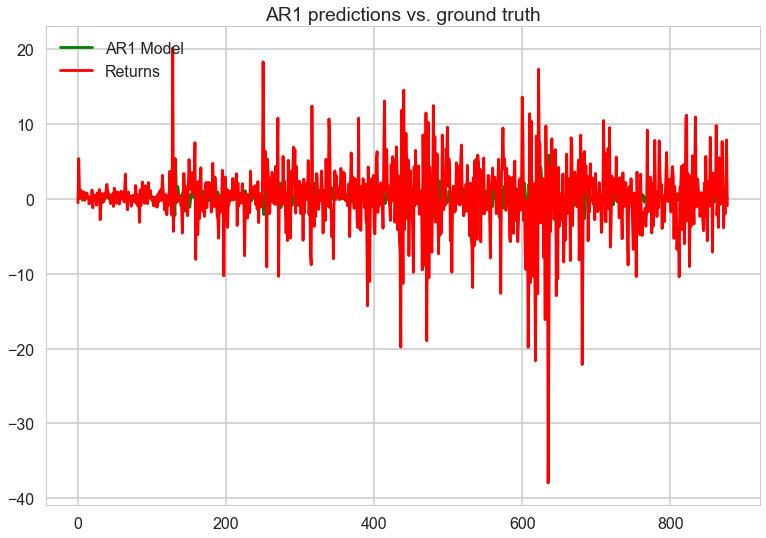

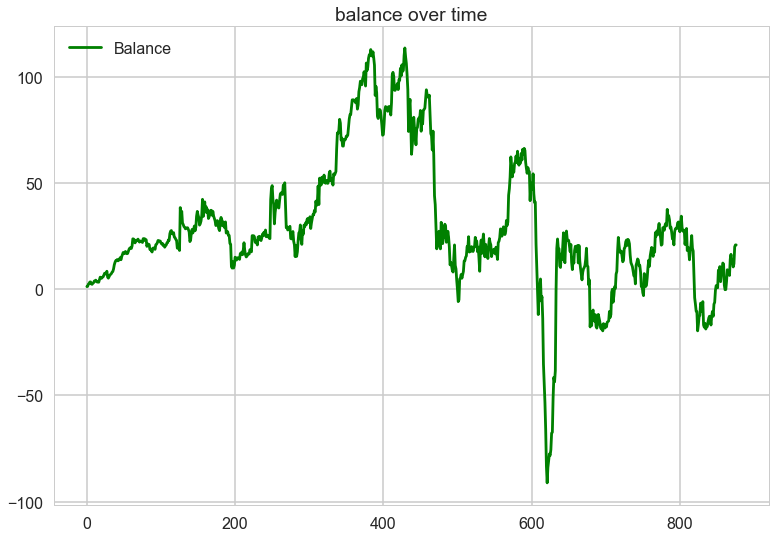

In [44]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions = []

thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    model = ARIMA(x_features[:current_t], order = (5,0,0))
    fitted_model = model.fit()
    prediction = fitted_model.forecast().reset_index(drop=True)
    predictions.append(prediction[0])
    

balances_theta_returns = simulate_trades_returns(predictions, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions, ts_label_1='AR1 Model', ts_2=x_features[start_t:], ts_label_2='Returns', title='AR1 predictions vs. ground truth')

plot_balance(data=balances_theta_returns)

# Grid searching ARIMA parameters

In [16]:
def evaluate_ARIMA_profit(data, order):
    num_days_year = 253
    ground_truth, start_t = data, int(num_days_year/2)
    assert len(data) > start_t

    predictions = list()
    thresholds = []
    training_X = data[:start_t].reset_index(drop=True)

    test_X = data[start_t:].reset_index(drop=True)

#     print("Predicting ARIMA with no thresholding")
    for t_i in (range(len(data) - start_t)):
        current_t = t_i + start_t
        threshold = 0
        thresholds.append(threshold)
        model = ARIMA(data[:current_t], order = order)
        fitted_model = model.fit()
        prediction = fitted_model.forecast().reset_index(drop=True)
        predictions.append(prediction[0])

#     print("RMSE of forecasting: ", sqrt(mean_squared_error(test_X, predictions)))
    balances_arima = simulate_trades_continuous(predictions, ground_truth[start_t:], thresholds)
    return balances_arima[len(balances_arima)-1]

def gridsearch_ARIMA(data, p_values, d_values, q_values):
    best_profit, best_order = -9999999, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                try:
                    balance = evaluate_ARIMA_profit(data, order)
                    if balance > best_profit:
                        best_profit, best_order = balance, order
                except:
                    continue
#     print('Best ARIMA%s Balance=%.3f' % (best_profit, best_order))
    return best_order

In [17]:
first_df = training_data.loc["AAPL"].dropna()

data = first_df.reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df.to_numpy(), int(num_days_year/2)

predictions = list()
thresholds = []
training_X = data[:start_t].reset_index(drop=True)

test_X = data[start_t:].reset_index(drop=True)
p_values = [1, 5, 10, 25]
d_values = range(0, 2)
q_values = range(0, 2)
ideal_order = gridsearch_ARIMA(data[:start_t*2], p_values, d_values, q_values)


(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)


/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 0)
(5, 0, 1)


/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(5, 1, 0)
(5, 1, 1)


/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

(10, 0, 0)
(10, 0, 1)


/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

(10, 1, 0)
(10, 1, 1)
(25, 0, 0)
(25, 0, 1)


/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/shantanu/Documents/Capstone/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

(25, 1, 0)
(25, 1, 1)


  0%|          | 0/880 [00:00<?, ?it/s]

Predicting ARIMA with no thresholding and grid search


TypeError: 'NoneType' object is not subscriptable

In [18]:
print(ideal_order)

None
